# Fine-Tune ResNet18 for Plant Classification

This notebook fine-tunes a ResNet18 model on your plant dataset (Rudo, Baya, Greg, Yuki).

## Steps:
1. Load and prepare dataset
2. Modify ResNet18 for 4 classes
3. Train the model
4. Evaluate and save

In [ ]:
# Install required packages
import sys
!{sys.executable} -m pip install "numpy<2.0" torch torchvision matplotlib tqdm --upgrade

In [3]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import os

In [4]:
# Import custom dataset class
import sys
sys.path.append('./')
from utils.datasets import ImageDataset

In [3]:
# Configuration
plant_names = ['Rudo', 'Baya', 'Greg', 'Yuki']
num_classes = 4

# Hyperparameters
batch_size = 16
num_epochs = 20
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {plant_names}")

Using device: cpu
Number of classes: 4
Class names: ['Rudo', 'Baya', 'Greg', 'Yuki']


In [4]:
# Load datasets
train_paths = glob.glob("./train/*.jpg")
val_paths = glob.glob("./val/*.jpg")
test_paths = glob.glob("./test/*.jpg")

print(f"Found {len(train_paths)} training images")
print(f"Found {len(val_paths)} validation images")
print(f"Found {len(test_paths)} test images")

# Create datasets
train_dataset = ImageDataset(train_paths, num_classes)
val_dataset = ImageDataset(val_paths, num_classes)
test_dataset = ImageDataset(test_paths, num_classes)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataloaders created successfully!")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Found 800 training images
Found 200 validation images
Found 80 test images

Dataloaders created successfully!
Train batches: 50
Val batches: 13
Test batches: 5


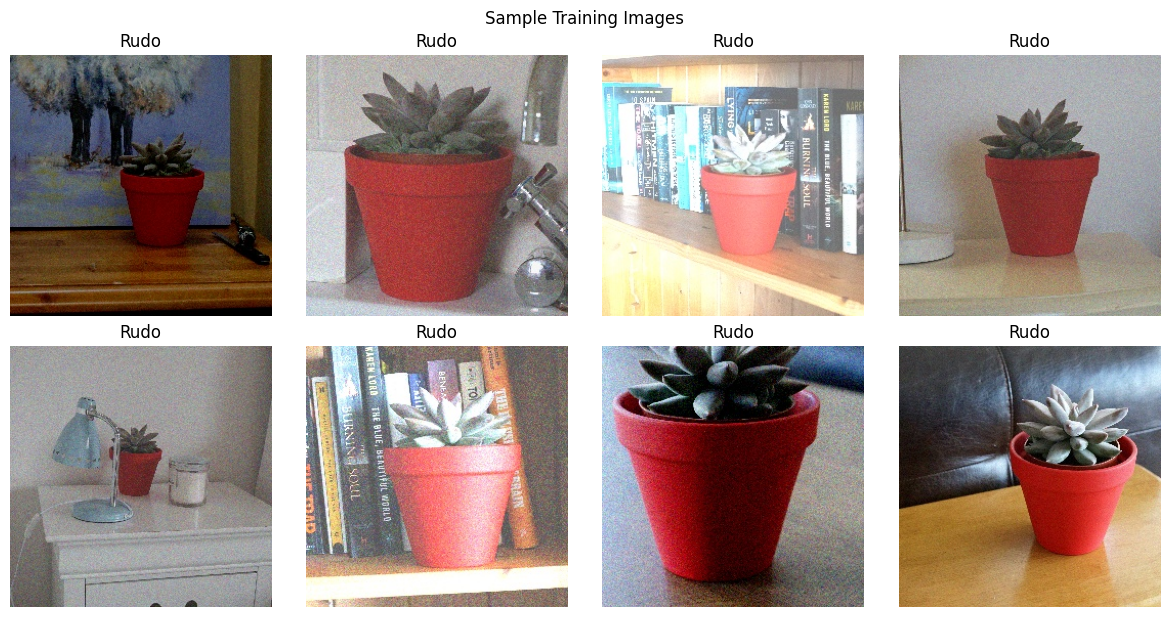

In [5]:
# Visualize sample images from training set
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(8):
    image, target = train_dataset[i]
    class_idx = torch.argmax(target).item()
    class_name = plant_names[class_idx]
    
    # Convert to numpy for display
    img_np = image.permute(1, 2, 0).numpy()
    
    axes[i].imshow(img_np)
    axes[i].set_title(f"{class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle("Sample Training Images", y=1.02)
plt.show()

In [6]:
# Load pretrained ResNet18 and modify for 4 classes
model = models.resnet18(pretrained=True)

# Freeze early layers (optional - comment out to train all layers)
# for param in model.parameters():
#     param.requires_grad = False

# Replace the final fully connected layer
# ResNet18 has 512 features before the fc layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Move model to device
model = model.to(device)

print(f"Model architecture modified for {num_classes} classes")
print(f"\nFinal layer: {model.fc}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

c:\Users\mahah\anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mahah\anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model architecture modified for 4 classes

Final layer: Linear(in_features=512, out_features=4, bias=True)
Total parameters: 11,178,564
Trainable parameters: 11,178,564


In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler (optional but recommended)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam (lr={learning_rate})")
print("Scheduler: StepLR (step_size=7, gamma=0.1)")

Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001)
Scheduler: StepLR (step_size=7, gamma=0.1)


In [8]:
# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    for images, targets in progress_bar:
        images = images.to(device)
        # Convert one-hot to class indices
        targets = torch.argmax(targets, dim=1).to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [9]:
# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validation")
        for images, targets in progress_bar:
            images = images.to(device)
            # Convert one-hot to class indices
            targets = torch.argmax(targets, dim=1).to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, targets)
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [10]:
# Training loop
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val_acc = 0.0

print("Starting training...\n")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate
    scheduler.step()
    
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_plant_classifier.pth')
        print(f"✓ Best model saved! (Val Acc: {val_acc:.2f}%)")
    
    print()

print(f"\nTraining complete!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

Starting training...

Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:11<00:00,  1.14it/s, loss=0.0438, acc=67.50%]



Train Loss: 0.2446 | Train Acc: 92.00%
Val Loss: 1.2223 | Val Acc: 67.50%
✓ Best model saved! (Val Acc: 67.50%)

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s, loss=0.0094, acc=98.00%]



Train Loss: 0.0953 | Train Acc: 97.62%
Val Loss: 0.0918 | Val Acc: 98.00%
✓ Best model saved! (Val Acc: 98.00%)

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s, loss=0.1071, acc=99.00%]



Train Loss: 0.0961 | Train Acc: 96.50%
Val Loss: 0.0401 | Val Acc: 99.00%
✓ Best model saved! (Val Acc: 99.00%)

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s, loss=0.1087, acc=93.00%]



Train Loss: 0.2021 | Train Acc: 94.88%
Val Loss: 0.2185 | Val Acc: 93.00%

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s, loss=0.0226, acc=97.00%]



Train Loss: 0.0611 | Train Acc: 98.38%
Val Loss: 0.0843 | Val Acc: 97.00%

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it, loss=0.2760, acc=93.00%]



Train Loss: 0.0648 | Train Acc: 98.25%
Val Loss: 0.2609 | Val Acc: 93.00%

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s, loss=0.0031, acc=99.00%] 



Train Loss: 0.1214 | Train Acc: 96.88%
Val Loss: 0.0247 | Val Acc: 99.00%

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s, loss=0.0038, acc=99.50%] 



Train Loss: 0.0176 | Train Acc: 99.38%
Val Loss: 0.0172 | Val Acc: 99.50%
✓ Best model saved! (Val Acc: 99.50%)

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s, loss=0.0028, acc=99.00%] 



Train Loss: 0.0190 | Train Acc: 99.62%
Val Loss: 0.0175 | Val Acc: 99.00%

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s, loss=0.0029, acc=99.00%] 



Train Loss: 0.0089 | Train Acc: 99.88%
Val Loss: 0.0183 | Val Acc: 99.00%

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:09<00:00,  1.30it/s, loss=0.0028, acc=99.00%] 



Train Loss: 0.0083 | Train Acc: 99.88%
Val Loss: 0.0189 | Val Acc: 99.00%

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s, loss=0.0022, acc=99.00%] 



Train Loss: 0.0091 | Train Acc: 99.75%
Val Loss: 0.0180 | Val Acc: 99.00%

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s, loss=0.0019, acc=99.00%] 



Train Loss: 0.0059 | Train Acc: 99.88%
Val Loss: 0.0164 | Val Acc: 99.00%

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s, loss=0.0015, acc=99.50%] 



Train Loss: 0.0103 | Train Acc: 99.62%
Val Loss: 0.0128 | Val Acc: 99.50%

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s, loss=0.0016, acc=99.00%] 



Train Loss: 0.0049 | Train Acc: 100.00%
Val Loss: 0.0151 | Val Acc: 99.00%

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s, loss=0.0016, acc=99.50%] 



Train Loss: 0.0044 | Train Acc: 100.00%
Val Loss: 0.0137 | Val Acc: 99.50%

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s, loss=0.0014, acc=99.00%] 



Train Loss: 0.0074 | Train Acc: 99.75%
Val Loss: 0.0153 | Val Acc: 99.00%

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s, loss=0.0010, acc=99.50%] 



Train Loss: 0.0130 | Train Acc: 99.75%
Val Loss: 0.0121 | Val Acc: 99.50%

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:09<00:00,  1.30it/s, loss=0.0016, acc=99.00%] 



Train Loss: 0.0052 | Train Acc: 99.88%
Val Loss: 0.0153 | Val Acc: 99.00%

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s, loss=0.0017, acc=99.00%] 


Train Loss: 0.0076 | Train Acc: 99.88%
Val Loss: 0.0174 | Val Acc: 99.00%


Training complete!
Best validation accuracy: 99.50%


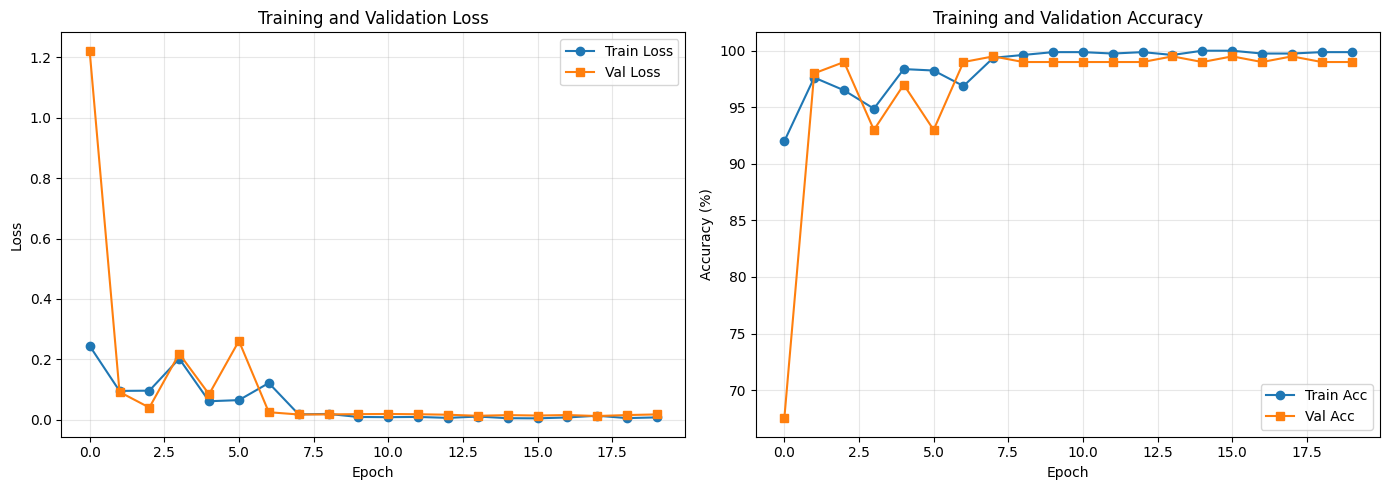

Training history plot saved as 'training_history.png'


In [11]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(val_losses, label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accs, label='Train Acc', marker='o')
ax2.plot(val_accs, label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training history plot saved as 'training_history.png'")

In [12]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Evaluating on test set...


Validation: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it, loss=0.0000, acc=75.00%]


Test Loss: 2.4615
Test Accuracy: 75.00%


C:\Users\mahah\AppData\Local\Temp\ipykernel_47188\1297480441.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_plant_classifier.pth'

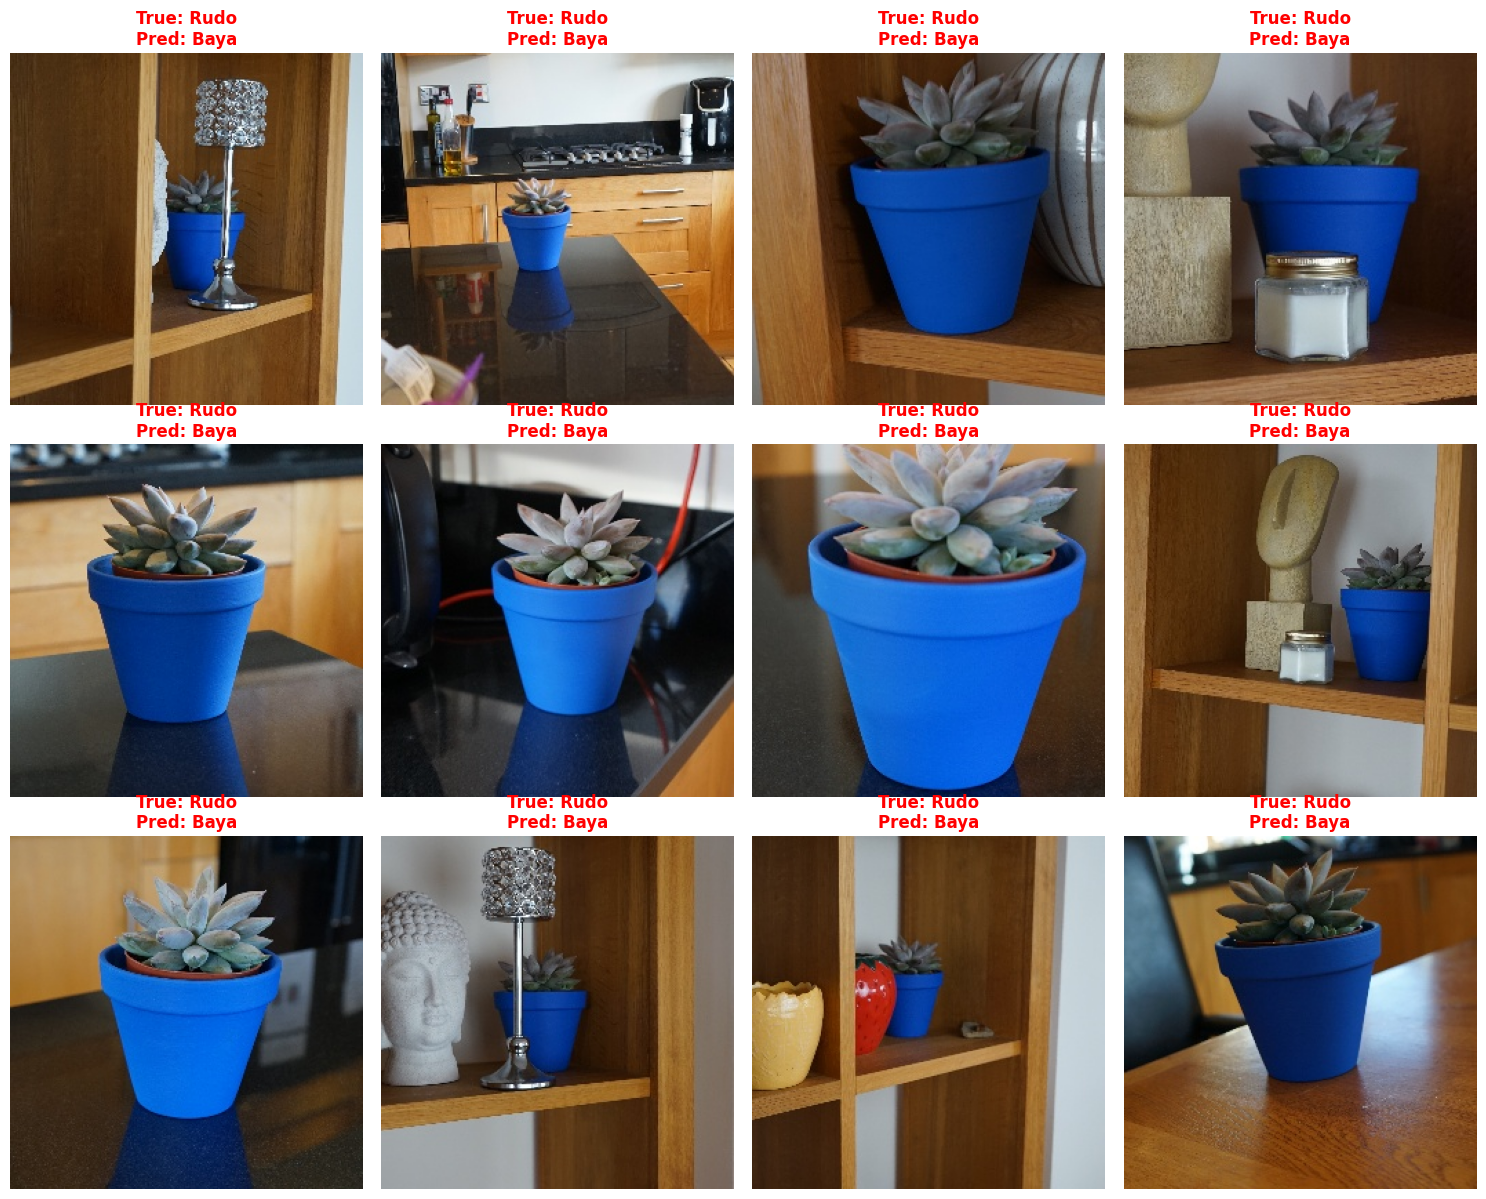

Test predictions saved as 'test_predictions.png'


In [13]:
# Load best model and test predictions
model.load_state_dict(torch.load('best_plant_classifier.pth'))
model.eval()

# Visualize predictions on test set
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
axes = axes.flatten()

with torch.no_grad():
    for i in range(12):
        image, target = test_dataset[i]
        true_class = torch.argmax(target).item()
        
        # Get prediction
        input_tensor = image.unsqueeze(0).to(device)
        output = model(input_tensor)
        pred_class = torch.argmax(output, dim=1).item()
        
        # Display
        img_np = image.permute(1, 2, 0).numpy()
        axes[i].imshow(img_np)
        
        # Color based on correctness
        color = 'green' if pred_class == true_class else 'red'
        axes[i].set_title(f"True: {plant_names[true_class]}\nPred: {plant_names[pred_class]}", 
                         color=color, fontweight='bold')
        axes[i].axis('off')

plt.tight_layout()
plt.savefig('test_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Test predictions saved as 'test_predictions.png'")

In [14]:
# Save final model with metadata
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': plant_names,
    'num_classes': num_classes,
    'best_val_acc': best_val_acc,
    'test_acc': test_acc,
    'architecture': 'resnet18'
}, 'plant_classifier_final.pth')

print("✓ Final model saved as 'plant_classifier_final.pth'")
print(f"\nModel Summary:")
print(f"  - Architecture: ResNet18")
print(f"  - Classes: {plant_names}")
print(f"  - Best Val Accuracy: {best_val_acc:.2f}%")
print(f"  - Test Accuracy: {test_acc:.2f}%")
print(f"\nTo use this model in MyFile.ipynb:")
print(f"  1. Load with: checkpoint = torch.load('plant_classifier_final.pth')")
print(f"  2. model.load_state_dict(checkpoint['model_state_dict'])")

✓ Final model saved as 'plant_classifier_final.pth'

Model Summary:
  - Architecture: ResNet18
  - Classes: ['Rudo', 'Baya', 'Greg', 'Yuki']
  - Best Val Accuracy: 99.50%
  - Test Accuracy: 75.00%

To use this model in MyFile.ipynb:
  1. Load with: checkpoint = torch.load('plant_classifier_final.pth')
  2. model.load_state_dict(checkpoint['model_state_dict'])


## Creating confision matrices

In [5]:
# CELL 1: Import required libraries for confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
# CELL 2: Load Train and Test datasets
# Load train data
train_paths = glob.glob("./train/*.jpg")
train_dataset = ImageDataset(train_paths, num_classes=4)

# Load test data (already loaded, but redefining for clarity)
test_paths = glob.glob("./test/*.jpg")
test_dataset = ImageDataset(test_paths, num_classes=4)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Train samples: 800
Test samples: 83


In [6]:
# CELL 3: Function to get predictions for entire dataset
def get_all_predictions(model, dataset, device):
    """
    Get predictions for all samples in a dataset.
    
    Args:
        model: Trained model
        dataset: ImageDataset instance
        device: torch device
    
    Returns:
        y_true: Ground truth labels (numpy array)
        y_pred: Predicted labels (numpy array)
    """
    model.eval()
    
    y_true = []
    y_pred = []
    
    print(f"Processing {len(dataset)} samples...")
    
    with torch.no_grad():
        for i in range(len(dataset)):
            # Get image and target
            image, target = dataset[i]
            
            # Get true label
            true_label = torch.argmax(target).item()
            
            # Get prediction
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            pred_label = torch.argmax(output).item()
            
            y_true.append(true_label)
            y_pred.append(pred_label)
            
            # Progress indicator
            if (i + 1) % 50 == 0:
                print(f"  Processed {i+1}/{len(dataset)} samples...")
    
    return np.array(y_true), np.array(y_pred)


In [10]:
# Import required libraries
import torch
import torch.nn as nn
import torchvision.models as models

# Create the model architecture (must match the saved model)
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)  # 4 classes for your plants

# Load the saved checkpoint
checkpoint = torch.load('plant_classifier_final.pth', weights_only=False)

# Load the model state dict
model.load_state_dict(checkpoint['model_state_dict'])

# Set device and move model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

# Print loaded information
print("✓ Model loaded successfully!")
print(f"Device: {device}")
print(f"Classes: {checkpoint['class_names']}")



✓ Model loaded successfully!
Device: cpu
Classes: ['Rudo', 'Baya', 'Greg', 'Yuki']


In [11]:
# CELL 4: Get predictions for train set
print("\n" + "="*60)
print("TRAIN SET EVALUATION")
print("="*60)

y_true_train, y_pred_train = get_all_predictions(model, train_dataset, device)

train_accuracy = (y_true_train == y_pred_train).mean() * 100
print(f"\nTrain Accuracy: {train_accuracy:.2f}%")
print(f"Correct predictions: {(y_true_train == y_pred_train).sum()}/{len(y_true_train)}")



TRAIN SET EVALUATION
Processing 800 samples...
  Processed 50/800 samples...
  Processed 100/800 samples...
  Processed 150/800 samples...
  Processed 200/800 samples...
  Processed 250/800 samples...
  Processed 300/800 samples...
  Processed 350/800 samples...
  Processed 400/800 samples...
  Processed 450/800 samples...
  Processed 500/800 samples...
  Processed 550/800 samples...
  Processed 600/800 samples...
  Processed 650/800 samples...
  Processed 700/800 samples...
  Processed 750/800 samples...
  Processed 800/800 samples...

Train Accuracy: 99.75%
Correct predictions: 798/800


In [12]:
# CELL 5: Get predictions for test set
print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

y_true_test, y_pred_test = get_all_predictions(model, test_dataset, device)

test_accuracy = (y_true_test == y_pred_test).mean() * 100
print(f"\nTest Accuracy: {test_accuracy:.2f}%")
print(f"Correct predictions: {(y_true_test == y_pred_test).sum()}/{len(y_true_test)}")



TEST SET EVALUATION
Processing 83 samples...
  Processed 50/83 samples...

Test Accuracy: 72.29%
Correct predictions: 60/83


In [13]:
# CELL 6: Plot confusion matrix function
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    """
    Plot a beautiful confusion matrix with percentages.
    
    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
        class_names: List of class names
        title: Title for the plot
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'}, ax=axes[0])
    axes[0].set_title(f'{title}\n(Counts)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    
    # Plot 2: Percentages
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Percentage (%)'}, ax=axes[1])
    axes[1].set_title(f'{title}\n(Percentages)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print per-class accuracy
    print(f"\n{title} - Per-Class Accuracy:")
    print("="*50)
    for i, class_name in enumerate(class_names):
        class_acc = cm[i, i] / cm[i].sum() * 100 if cm[i].sum() > 0 else 0
        print(f"{class_name:10s}: {class_acc:6.2f}% ({cm[i, i]}/{cm[i].sum()})")
    
    overall_acc = np.diag(cm).sum() / cm.sum() * 100
    print(f"{'Overall':10s}: {overall_acc:6.2f}% ({np.diag(cm).sum()}/{cm.sum()})")
    
    return cm



TRAIN SET CONFUSION MATRIX


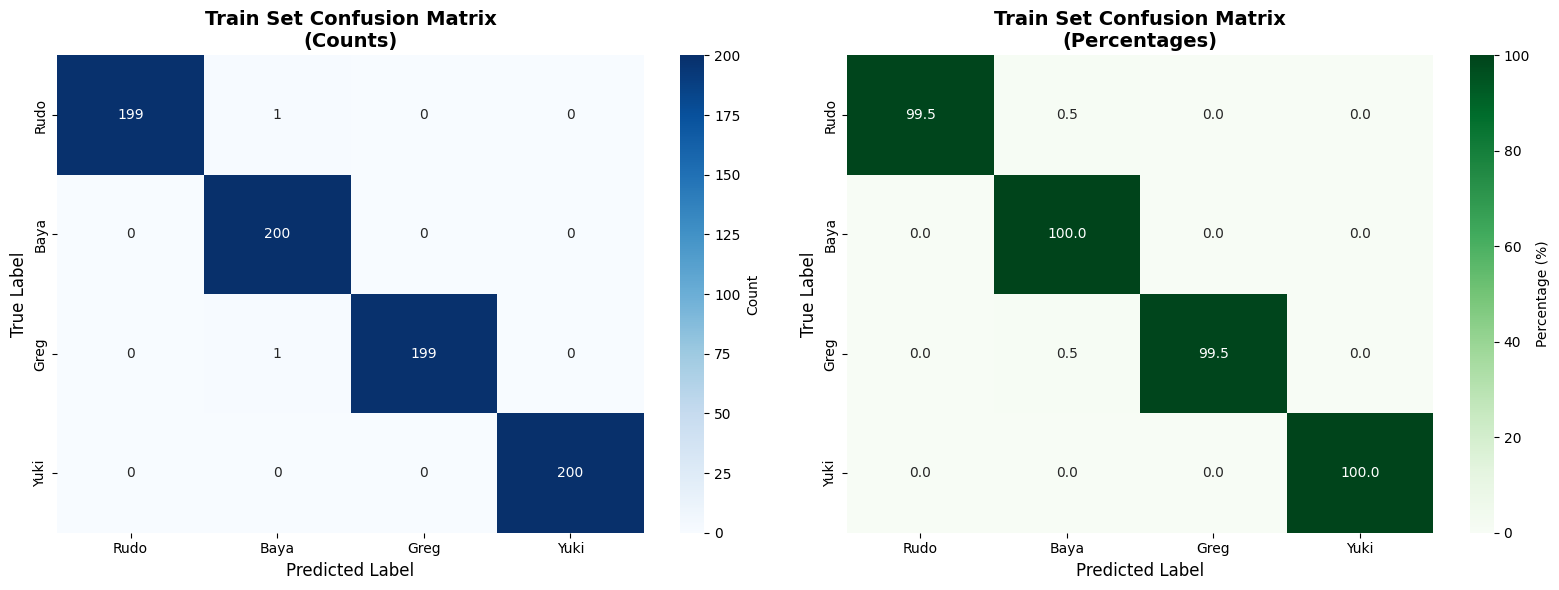


Train Set Confusion Matrix - Per-Class Accuracy:
Rudo      :  99.50% (199/200)
Baya      : 100.00% (200/200)
Greg      :  99.50% (199/200)
Yuki      : 100.00% (200/200)
Overall   :  99.75% (798/800)


In [15]:
# CELL 7: Plot Train Confusion Matrix
print("\n" + "="*60)
print("TRAIN SET CONFUSION MATRIX")
print("="*60)

cm_train = plot_confusion_matrix(y_true_train, y_pred_train, checkpoint['class_names'], 
                                  title='Train Set Confusion Matrix')



TEST SET CONFUSION MATRIX


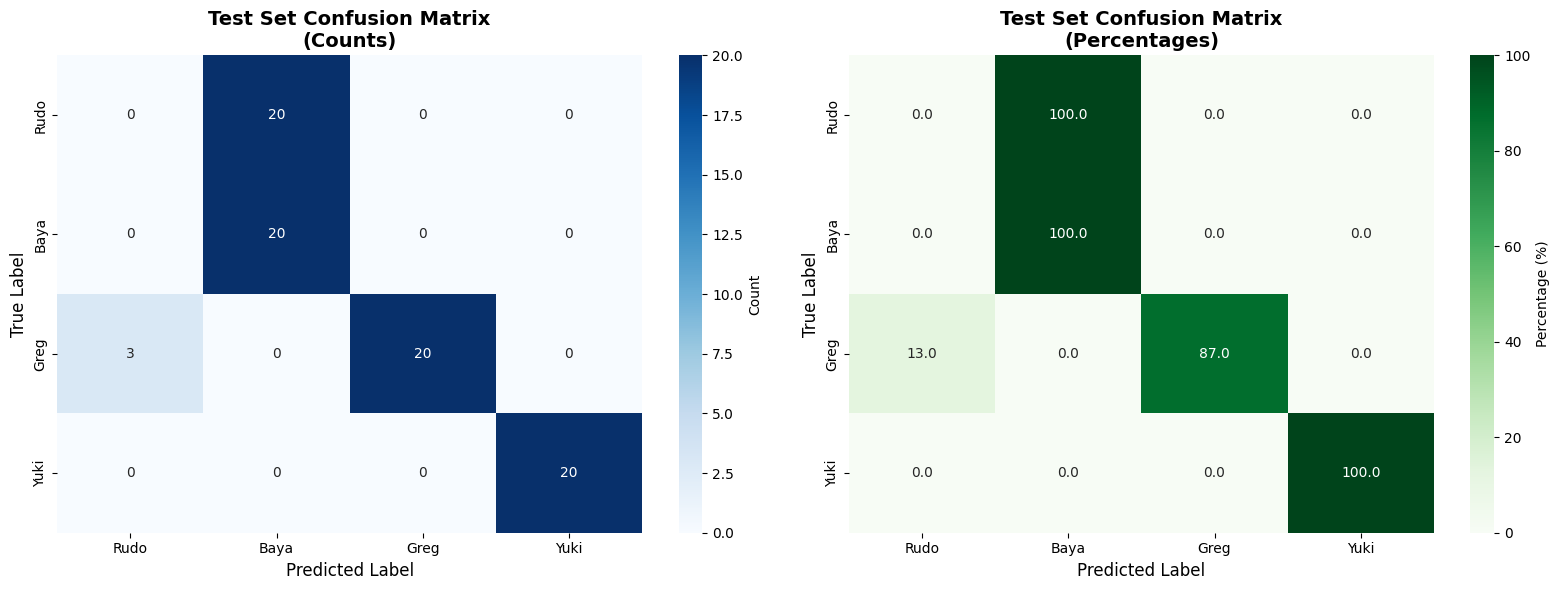


Test Set Confusion Matrix - Per-Class Accuracy:
Rudo      :   0.00% (0/20)
Baya      : 100.00% (20/20)
Greg      :  86.96% (20/23)
Yuki      : 100.00% (20/20)
Overall   :  72.29% (60/83)


In [16]:
# CELL 8: Plot Test Confusion Matrix
print("\n" + "="*60)
print("TEST SET CONFUSION MATRIX")
print("="*60)

cm_test = plot_confusion_matrix(y_true_test, y_pred_test, checkpoint['class_names'],
                                 title='Test Set Confusion Matrix')


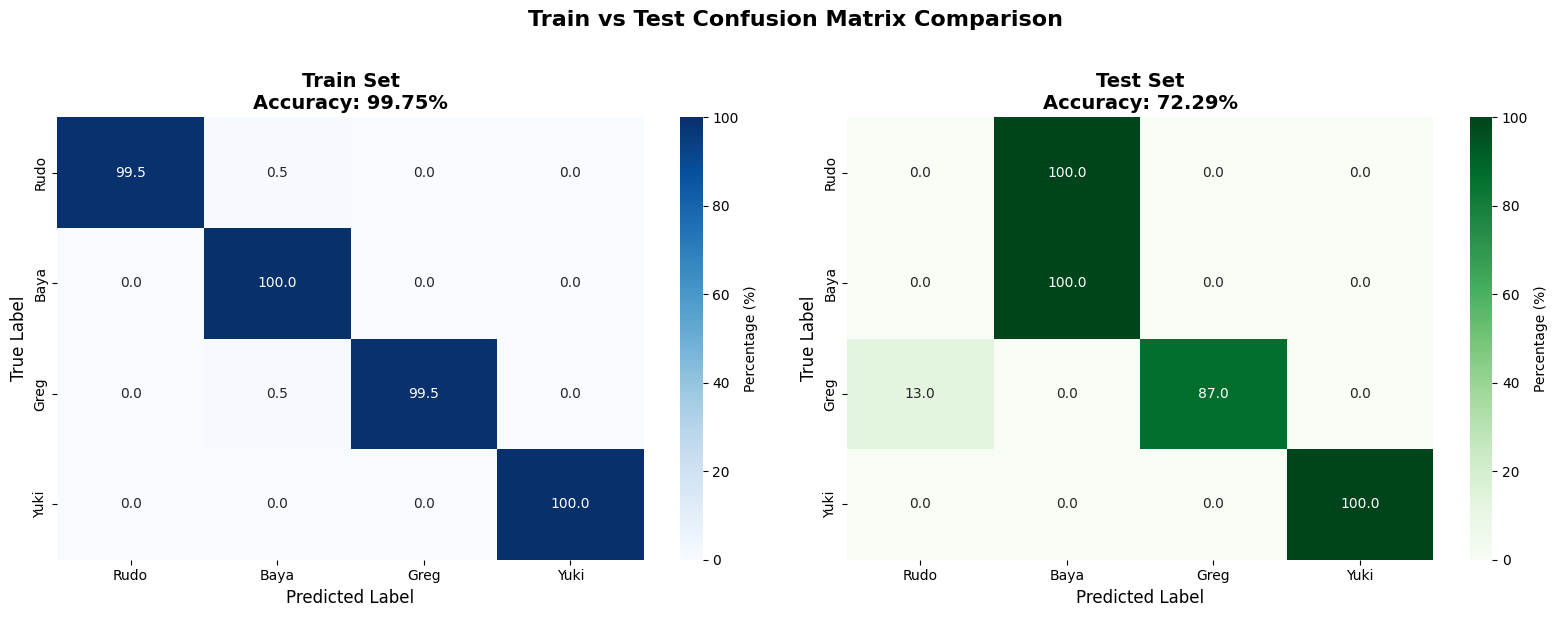


✓ Confusion matrix analysis complete!


In [19]:
# CELL 10: Side-by-side comparison
# Compare train vs test confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train confusion matrix
cm_train_percent = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_train_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=checkpoint['class_names'], yticklabels=checkpoint['class_names'],
            cbar_kws={'label': 'Percentage (%)'}, ax=axes[0], vmin=0, vmax=100)
axes[0].set_title(f'Train Set\nAccuracy: {train_accuracy:.2f}%', 
                 fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Test confusion matrix
cm_test_percent = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_test_percent, annot=True, fmt='.1f', cmap='Greens',
            xticklabels=checkpoint['class_names'], yticklabels=checkpoint['class_names'],
            cbar_kws={'label': 'Percentage (%)'}, ax=axes[1], vmin=0, vmax=100)
axes[1].set_title(f'Test Set\nAccuracy: {test_accuracy:.2f}%', 
                 fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.suptitle('Train vs Test Confusion Matrix Comparison', 
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ Confusion matrix analysis complete!")
